**Modelo de red neuronal Transformer**

Este archivo consta de los codigos de:
* 1.Carga de librerias y datos
* 2.Proceso de entrenamiento
  * 2.1. Separacion de datos en train y test
  * 2.2 Modelo Transformer
* 3.Evaluacion del modelo
* 4.Exportar resultados


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

##Carga de librerias

In [ ]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Ignorar warnings

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dropout, GRU, Dense, Activation,Input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time,os
# Transformer with Bayesian optimization and Cross-validation
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.layers import LayerNormalization, MultiHeadAttention, Add
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico

/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico


##Se obtiene conjunto de datos

In [ ]:
predictor_variables=pd.read_csv('predictor_variables.csv' ,index_col='dt')
target_variables=pd.read_csv('target_variables.csv' ,index_col='dt')

In [ ]:
#Setear semilla
np.random.seed(42)

#2.Proceso de entrenamiento

**Se establece los parametros de:**

In [ ]:
#Se establece porcentaje de usado para test
PORCENTAJE_TEST=0.2

#Se define la cantidad de intentos de la optimizacion bayesiana
INTENTOS=100

##2.1. Separacion de data en train y test

In [ ]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=PORCENTAJE_TEST, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [ ]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],1,Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0],1, Y_test.shape[1]))

##2.2. Modelo Transformer

In [ ]:
import time

In [ ]:
# Ajustar parámetros para reproducibilidad del entrenamiento
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Transformer with Bayesian optimization and Cross-validation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.layers import LayerNormalization, MultiHeadAttention, Add
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization()(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

In [ ]:
def create_model(head_size, dropout,num_heads,learning_rate,ff_dim):
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = inputs
    for _ in range(2):  # two transformer blocks
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    outputs = TimeDistributed(Dense(1))(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [ ]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    head_size = params['head_size']
    num_heads = params['num_heads']
    ff_dim  = params['ff_dim']
    dropout  = params['dropout']
    epochs = params['epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    scores_test=[]
    times=[]
    models=[]
    aux=1000

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de Transformer
      model = create_model(int(head_size), float(dropout),int(num_heads),float(learning_rate),int(ff_dim))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      if(score_test[0]<aux):
        aux=score_test[0]
        best_model=model
        hist_=hist

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return{'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': best_model,
            'params': params,
            'hist':hist_,
            'time':times,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [ ]:

# Define the search space for hyperparameters
space = {
    'head_size': hp.quniform('head_size', 64, 256, 32),
    'num_heads':hp.quniform('num_heads', 4, 8, 1),
    'ff_dim': hp.quniform('ff_dim', 64, 256, 32),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005),
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
}

In [ ]:
'''
space = {
    'head_size':500,
    'num_heads':10,
    'ff_dim': 500,
    'dropout':0.59,
    'learning_rate': 0.00005,
    'epochs': 800,
    'batch_size': 30,
}
'''

"\nspace = {\n    'head_size':500,\n    'num_heads':10,\n    'ff_dim': 500,\n    'dropout':0.59,\n    'learning_rate': 0.00005,\n    'epochs': 800,\n    'batch_size': 30,\n}\n"

In [ ]:
# Bayesian optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=INTENTOS, trials=trials)


100%|██████████| 1/1 [02:50<00:00, 170.78s/trial, best loss: 54.76914372682572]


In [ ]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']

In [ ]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 30.0,
 'dropout': 0.5505180613367431,
 'epochs': 800,
 'ff_dim': 160.0,
 'head_size': 160.0,
 'learning_rate': 3.6885133073677454e-05,
 'num_heads': 8.0}

# 3.Evaluacion del modelo

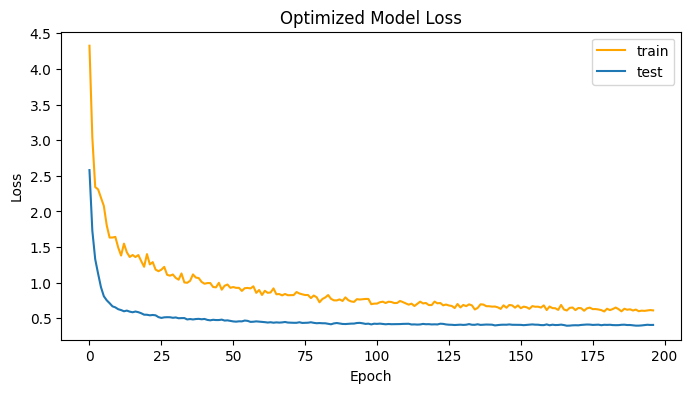

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
#Se realiza prediccion
results = best_model.predict(X_test)

9/9 [==============================] - 0s 4ms/step


In [ ]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

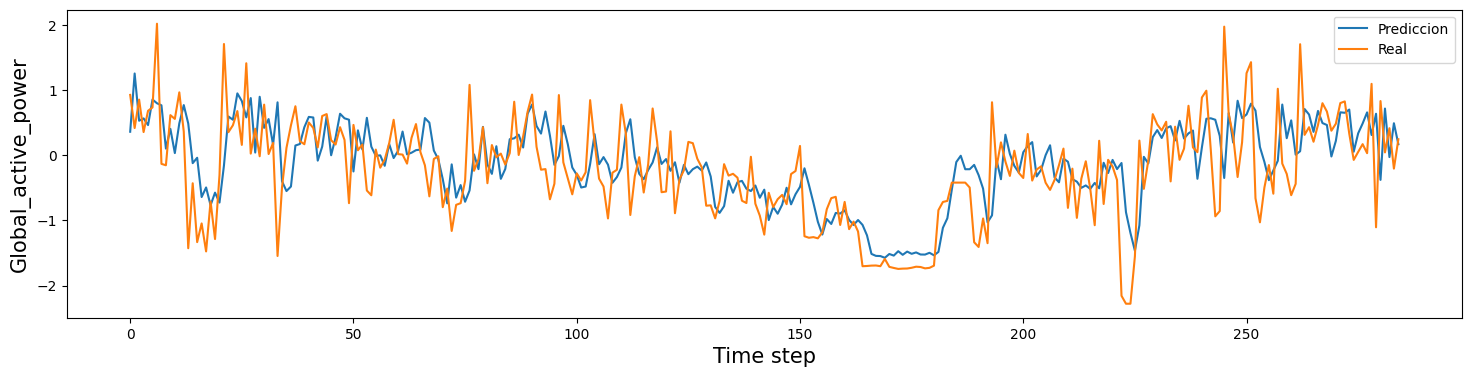

In [ ]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [ ]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3829362094402313
RMSE: 0.6188184022903442
MAE: 0.45202475786209106
MAPE: 220.0372314453125


#4.Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [43]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "Transformer_CE" + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['head_size'])+"_"+str(result['params']['num_heads'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['ff_dim'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [44]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])


In [45]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
4,Transformer_CE_800_30.0_160.0_8.0_0.55_160.0_3...,1,5,48.575975,0.382936,0.618818,0.452025,220.037231
3,Transformer_CE_800_30.0_160.0_8.0_0.55_160.0_3...,1,4,46.951588,0.418307,0.646767,0.473294,257.192902
2,Transformer_CE_800_30.0_160.0_8.0_0.55_160.0_3...,1,3,20.728234,0.466245,0.682822,0.510440,291.703491
1,Transformer_CE_800_30.0_160.0_8.0_0.55_160.0_3...,1,2,25.404007,0.592942,0.770028,0.576243,377.730988
0,Transformer_CE_800_30.0_160.0_8.0_0.55_160.0_3...,1,1,23.648713,0.921558,0.959978,0.766428,577.808472


In [46]:
# Exportar el DataFrame como CSV
folder_path = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_csv'
csv_filename = 'results_Transformers_CE.csv'
csv_path = os.path.join(folder_path, csv_filename)
results_csv.to_csv(csv_path, index=False)

Se guarda cada modelo keras en un objeto Json

In [47]:
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-ConsumoElectrico/Resultados_Modelos/results_Transformers'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [48]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "Transformer_CE" + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['head_size'])+"_"+str(result['params']['num_heads'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['ff_dim'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1